<a href="https://colab.research.google.com/github/Anisafi/T2-deeplearning/blob/main/Klasifikasi_Sikat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Klasifikasi Gambar Sikat - Pipeline Lengkap + Styling, Output Estetik, dan Penanganan Overfitting

import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive

# 0. Mount Google Drive
drive.mount('/content/drive')

# Path dataset di Google Drive
gdrive_path = '/content/drive/MyDrive/DeepLearning_T2/dataset_sikat'
base_dir = gdrive_path
categories = ['sikat_pakaian', 'sikat_gigi', 'sikat_botol', 'sikat_kloset']


Mounted at /content/drive


In [2]:
# 1. Struktur Folder Dataset
for split in ['train', 'val', 'test']:
    for category in categories:
        os.makedirs(os.path.join(base_dir, split, category), exist_ok=True)

train_split, val_split = 0.7, 0.15

for category in categories:
    source_dir = os.path.join(base_dir, category)
    if not os.path.exists(source_dir):
        continue
    images = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]
    random.shuffle(images)
    total = len(images)
    train_end = int(train_split * total)
    val_end = int((train_split + val_split) * total)
    for img in images[:train_end]:
        shutil.move(os.path.join(source_dir, img), os.path.join(base_dir, 'train', category, img))
    for img in images[train_end:val_end]:
        shutil.move(os.path.join(source_dir, img), os.path.join(base_dir, 'val', category, img))
    for img in images[val_end:]:
        shutil.move(os.path.join(source_dir, img), os.path.join(base_dir, 'test', category, img))
    if not os.listdir(source_dir):
        os.rmdir(source_dir)

In [3]:
#2. Data Generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(os.path.join(base_dir, 'train'), target_size=(224, 224), batch_size=32, class_mode='categorical')
val_generator = val_datagen.flow_from_directory(os.path.join(base_dir, 'val'), target_size=(224, 224), batch_size=32, class_mode='categorical')

Found 840 images belonging to 4 classes.
Found 180 images belonging to 4 classes.


In [4]:
# 3. Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(len(categories), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
# 4. Training
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
if train_generator.samples > 0 and val_generator.samples > 0:
    history = model.fit(train_generator, validation_data=val_generator, epochs=50, callbacks=[early_stop])
    model.save(os.path.join(gdrive_path, 'model_sikat.h5'))
else:
    print("Dataset kosong atau tidak lengkap.")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 548s 21s/step - accuracy: 0.4303 - loss: 3.6636 - val_accuracy: 0.9444 - val_loss: 2.7934
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 187s 6s/step - accuracy: 0.7928 - loss: 2.8241 - val_accuracy: 0.9556 - val_loss: 2.4848
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 169s 6s/step - accuracy: 0.8804 - loss: 2.5930 - val_accuracy: 0.9500 - val_loss: 2.3382
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 184s 7s/step - accuracy: 0.9310 - loss: 2.4005 - val_accuracy: 0.9611 - val_loss: 2.2356
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 172s 6s/step - accuracy: 0.9488 - loss: 2.2795 - val_accuracy: 0.9722 - val_loss: 2.1498
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 169s 6s/step - accuracy: 0.9516 - loss: 2.1943 - val_accuracy: 0.9722 - val_loss: 2.0703
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 170s 6s/step - accuracy: 0.9645 - loss: 2.1113 - val_accuracy: 0.9778 - val_loss: 2.0024
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 173s 6s/step - accuracy: 0.9670 - loss: 2.0353 - val_accuracy: 0.9778 - 

In [6]:
# Pastikan test_generator sudah dibuat
test_generator = val_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Evaluasi performa
test_loss, test_acc = model.evaluate(test_generator)
print(f"\n[🔍] Test Accuracy: {test_acc * 100:.2f}%")
print(f"[🔍] Test Loss: {test_loss:.4f}")


Found 180 images belonging to 4 classes.
6/6 ━━━━━━━━━━━━━━━━━━━━ 90s 17s/step - accuracy: 0.9927 - loss: 0.5473

[🔍] Test Accuracy: 99.44%
[🔍] Test Loss: 0.5449


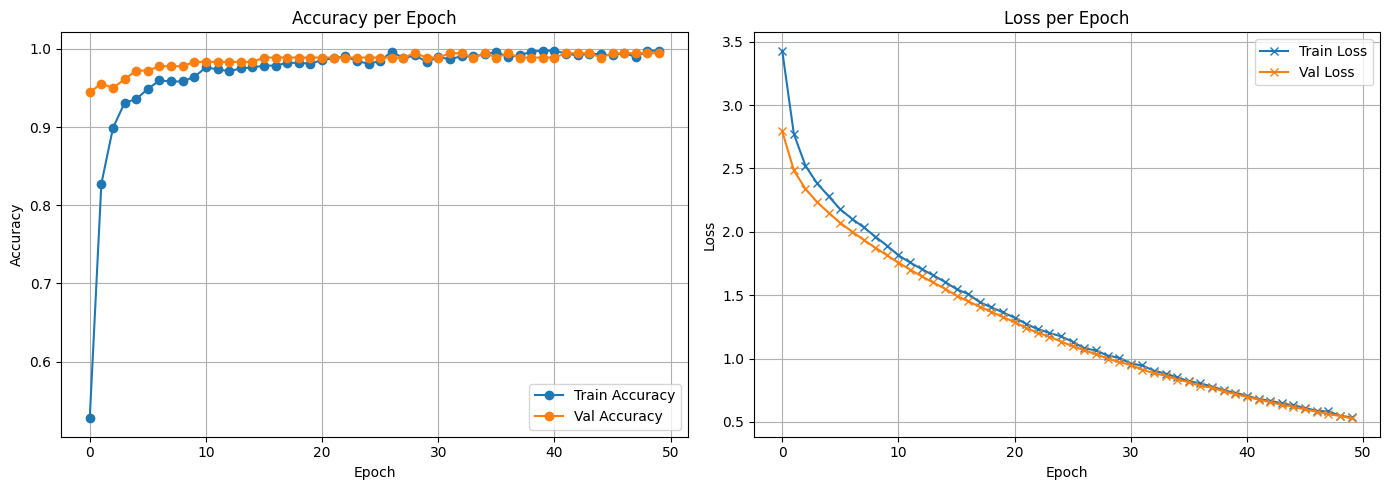

In [7]:
# Plot accuracy & loss
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='x')
plt.plot(history.history['val_loss'], label='Val Loss', marker='x')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step


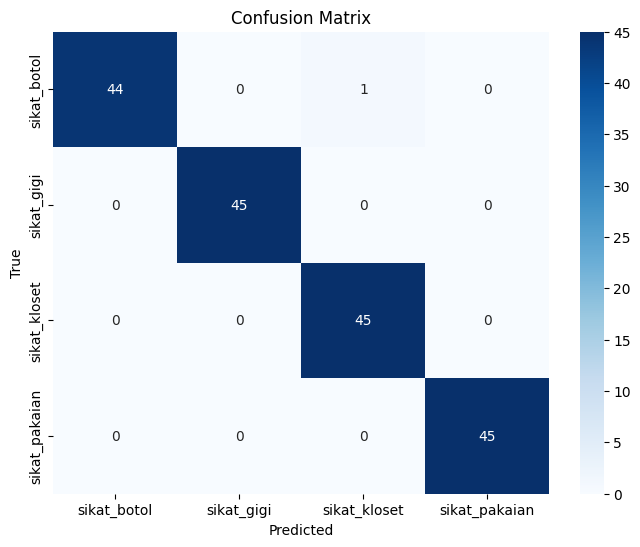

[🧾] Classification Report:
               precision    recall  f1-score   support

  sikat_botol       1.00      0.98      0.99        45
   sikat_gigi       1.00      1.00      1.00        45
 sikat_kloset       0.98      1.00      0.99        45
sikat_pakaian       1.00      1.00      1.00        45

     accuracy                           0.99       180
    macro avg       0.99      0.99      0.99       180
 weighted avg       0.99      0.99      0.99       180



In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Dapatkan prediksi
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report
print("[🧾] Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


In [9]:
import tensorflow.keras.backend as K
import cv2

def get_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [10]:
def overlay_heatmap(heatmap, img, alpha=0.4, colormap=cv2.COLORMAP_JET):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_colored = cv2.applyColorMap(heatmap, colormap)
    overlayed = cv2.addWeighted(heatmap_colored, alpha, img, 1 - alpha, 0)
    return overlayed
